<a href="https://colab.research.google.com/github/rkn2/factorAnalysisExample/blob/master/FactorAnalysisPersonality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background on the data

A personality test is given to a large group of people. There are 5 questions which deal with agreeableness (A1-5), 5 questions which deal with conscientiousness (C1-5), 5 questions which deal with Extraversion(E1-5), 5 questions which deal with Neuroticism (N1-5) and 5 questions which deal with Openness (O1-5). 

Those answers are directly related with one another.

We want to see if based on people's answers, we can regroup those categories.
If we can, we will end up with 5 factors and each factor will be influenced by the questions which correspond to it. 



# Pre-processing our data


## Loading the data

This step just installs any packages we will need to run the analysis code. You don't have to worry about any specifics here.

In [2]:
# Import required libraries
import pandas as pd
from sklearn.datasets import load_iris
#!pip install factor_analyzer
!pip install factor_analyzer==0.2.3
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import numpy as np


!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Now we will load the data. This line reads in the comma separated value sheet.

If you are given sensor data in excel and want to export it to csv in the future, see this link:
https://www.ablebits.com/office-addins-blog/2014/04/24/convert-excel-csv/

In [0]:
#url = 'https://raw.githubusercontent.com/rkn2/factorAnalysisExample/master/testDataSmall.csv' #you can change this link depending on your data
url = 'https://raw.githubusercontent.com/rkn2/factorAnalysisExample/master/bfi%20(1).csv'
df = pd.read_csv(url)
#df= pd.read_csv("testDataSmall.csv") # you can also just upload data using the interface on the left and use this reader here.

## Cleaning the data

Now we can start to process our data and remove any columns we don't want. We don't need the 'true ground water' 'wind driven rain' 'corSet', or 'notCor' columns since those were only needed to generate the synthetic data.

Additionally, we want to remove anywhere that there is missing data.

In [5]:
#index columns
df.columns

#drop unnecessary columns
unnecessaryColumns = ['gender','age','education']#this list is the only thing you would need to change
#unnecessaryColumns = ['corSet', 'notCor', 'true ground water', 'wind driven rain'] #this list is the only thing you would need to change
df.drop(unnecessaryColumns,axis=1,inplace=True) 

#drop any missing value rows
df.dropna(inplace=True)

#view information if you want
df.info()
#df.head()

#calcualte the number of variables
numVars = df.shape[1]-len(unnecessaryColumns)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2436 entries, 0 to 2799
Data columns (total 26 columns):
Unnamed: 0    2436 non-null int64
A1            2436 non-null float64
A2            2436 non-null float64
A3            2436 non-null float64
A4            2436 non-null float64
A5            2436 non-null float64
C1            2436 non-null float64
C2            2436 non-null float64
C3            2436 non-null float64
C4            2436 non-null float64
C5            2436 non-null float64
E1            2436 non-null float64
E2            2436 non-null float64
E3            2436 non-null float64
E4            2436 non-null float64
E5            2436 non-null float64
N1            2436 non-null float64
N2            2436 non-null float64
N3            2436 non-null float64
N4            2436 non-null float64
N5            2436 non-null float64
O1            2436 non-null float64
O2            2436 non-null int64
O3            2436 non-null float64
O4            2436 non-null float

# Check that factor analysis applies


Factor analysis code based on: https://www.datacamp.com/community/tutorials/introduction-factor-analysis

## Bartlett's test



The first way we can do this is using *bartlett's test* which checks whether the data is *statistically significant* by checking whether or not the observed variabels intercorrelate at all using the observed correlation matrix against the identity matrix. If the test is found statistically insignificant, you should not use factor analysis. 

In [6]:
#this is not something you need to change
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df)
chi_square_value, p_value

(18184.306307820552, 0.0)

In this Bartlett ’s test, the p-value is 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.

## Kaiser-Meyer-Olkin test

The second step we can do is the *Kaiser-Meyer-Olkin (KMO*) Test which measures the *suitability of data for factor analysis*. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [7]:
#this is not something you need to change
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df)

kmo_model

0.8483267027192358

The overall KMO for our data is 0.85, which is excellent. This value indicates that you can proceed with your planned factor analysis.

# Applying factor analysis

## Choosing the number of factors

Now we need to choose the number of factors. For this, we can use the Kaiser criterion and scree plot. Both are based on eigen values. 

In [8]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa.analyze(df, numVars, rotation=None) 
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

,Original_Eigenvalues
0,5.134580
1,2.753375
2,2.148142
3,1.852506
4,1.548463
5,1.110662
6,0.980677
7,0.824309
8,0.795162
9,0.718290


Here, you can see only for 6-factors eigenvalues are greater than one. It means we need to choose only 6 factors (or unobserved variables). But this is only a first step metric, next we can generate a Scree plot to see which of those 6 are really distinct from the pack.

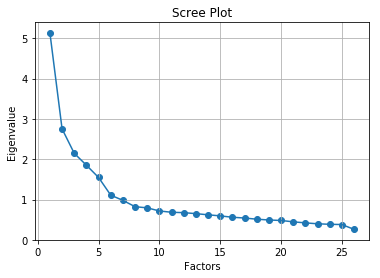

In [9]:
# Create scree plot using matplotlib
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

The scree plot method draws a straight line for each factor and its eigenvalues. Number eigenvalues greater than one considered as the number of factors.

Here, you can see again 6-factors eigenvalues are greater than one. It means we need to choose only 6 factors (or unobserved variables).

However something we can additionally, see is that after the first 5, there really isnt a diffence in the eigenvalues. So really only the first two are significant. Therefore we will only choose **5 factors**.

## Running factor analysis



In [10]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
numFactors = 5 # this will vary based on what you saw above
fa.analyze(df, numFactors, rotation="varimax")
fa.loadings

,Factor1,Factor2,Factor3,Factor4,Factor5
Unnamed: 0,-0.061703,-0.019246,0.034865,0.014345,-0.018678
A1,0.030705,0.106455,0.027567,-0.074133,-0.429612
A2,0.227127,0.028693,0.141159,0.064117,0.621801
A3,0.329927,0.005335,0.115928,0.061647,0.642856
A4,0.209217,-0.069443,0.235418,-0.108647,0.431241
A5,0.397690,-0.129002,0.097901,0.075363,0.528159
C1,0.048297,0.009548,0.548276,0.212169,0.041194
C2,0.014459,0.089975,0.650304,0.116582,0.105693
C3,0.010825,-0.030243,0.555781,-0.004812,0.114165
C4,-0.039326,0.240794,-0.633576,-0.109695,-0.041462


## Translating this into something we can understand a bit better

In [13]:

L = np.array(fa.loadings)
headings = list( fa.loadings.transpose().keys() )
factor_threshold = 0.25
for i, factor in enumerate(L.transpose()):
  descending = np.argsort(np.abs(factor))[::-1]
  contributions = [(np.round(factor[x],2),headings[x]) for x in descending if np.abs(factor[x])>factor_threshold]
  print('Factor %d:'%(i+1),contributions)

Factor 1: [(-0.67, 'E2'), (0.65, 'E4'), (-0.58, 'E1'), (0.53, 'E3'), (0.49, 'E5'), (0.4, 'A5'), (0.33, 'A3'), (-0.33, 'N4'), (0.3, 'O3')]
Factor 2: [(0.78, 'N1'), (0.75, 'N2'), (0.73, 'N3'), (0.6, 'N4'), (0.54, 'N5'), (0.29, 'C5'), (0.26, 'E2')]
Factor 3: [(0.65, 'C2'), (-0.63, 'C4'), (-0.57, 'C5'), (0.56, 'C3'), (0.55, 'C1'), (0.33, 'E5')]
Factor 4: [(0.6, 'O3'), (-0.53, 'O5'), (0.51, 'O1'), (-0.47, 'O2'), (0.36, 'O4'), (0.29, 'E3')]
Factor 5: [(0.64, 'A3'), (0.62, 'A2'), (0.53, 'A5'), (0.43, 'A4'), (-0.43, 'A1'), (0.29, 'E4')]


**So what does this mean?**

## Solution




Factor 1 is mostly influenced by the questions about extrovertedness (E); some parts of agreeableness, openness, and nueroticism, influence this, but it is mostly E. These were the original E questions.

Factor 2 is mostly influenced by neuroticism (N), but smoe parts of extrovertedness and conscientiousness play a role. These were the original N questions.

Factor 3 is mostly influenced by conscientiousness, but extrovertedness can play a role.
These were the original C questions.

Factor 4 is mostly influenced by openness but extrovertedness plays a role.
These were the original O questions.

Factor 5 is mostly influenced by agreeableness but extrovertedness plays a role.
These were the original A questions.

In summary, we were able to extract the original groupings however it was interesting to note the role that E plays in all of the questions. This could suggest that there is some bias or systematic error at play. 

# Computing the variance

In [0]:
# Get variance of each factors
fa.get_factor_variance()

,Factor1,Factor2,Factor3,Factor4,Factor5
SS Loadings,2.428049,2.736109,2.082504,1.549502,1.800505
Proportion Var,0.093387,0.105235,0.080096,0.059596,0.069250
Cumulative Var,0.093387,0.198621,0.278718,0.338314,0.407564


Total 41% cumulative Variance explained by the 2 factors.

**Pros and Cons of Factor Analysis**

Factor analysis explores large dataset and finds interlinked associations. It reduces the observed variables into a few unobserved variables or identifies the groups of inter-related variables, which help the market researchers to compress the market situations and find the hidden relationship among consumer taste, preference, and cultural influence. Also, It helps in improve questionnaire in for future surveys. Factors make for more natural data interpretation.

Results of factor analysis are controversial. Its interpretations can be debatable because more than one interpretation can be made of the same data factors. After factor identification and naming of factors requires domain knowledge.